# Data Wrangling on Time Series Datasets

Data wrangling in time series datasets usually consists of 4 main steps:
- Analyze Missing Data
- Align timescales using up/downsampling
- Perform smoothing
- Extract seasonality

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
# Plotting functions
def plot_lineplot_time_series(data, x, y):
    
    # Basic plotting
    plt.figure(figsize=(15,5))
    sns.lineplot(data=data, x=x, y=y)

    # Format tick labels
    plt.xticks(rotation=45)

def plot_scatter_time_series(data, x, y):
    
    # Basic plotting
    plt.figure(figsize=(15,5))
    sns.scatterplot(data=data, x=x, y=y)

    # Format tick labels
    plt.xticks(rotation=45)

# 0. Load Source Data
## 0.1 Air Passangers Dataset

In [3]:
AirPassengers = pd.read_csv("./datasets/AirPassengers.csv")
AirPassengers['Month'] = pd.to_datetime(AirPassengers['Month'])
AirPassengers.head()

,Month,#Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


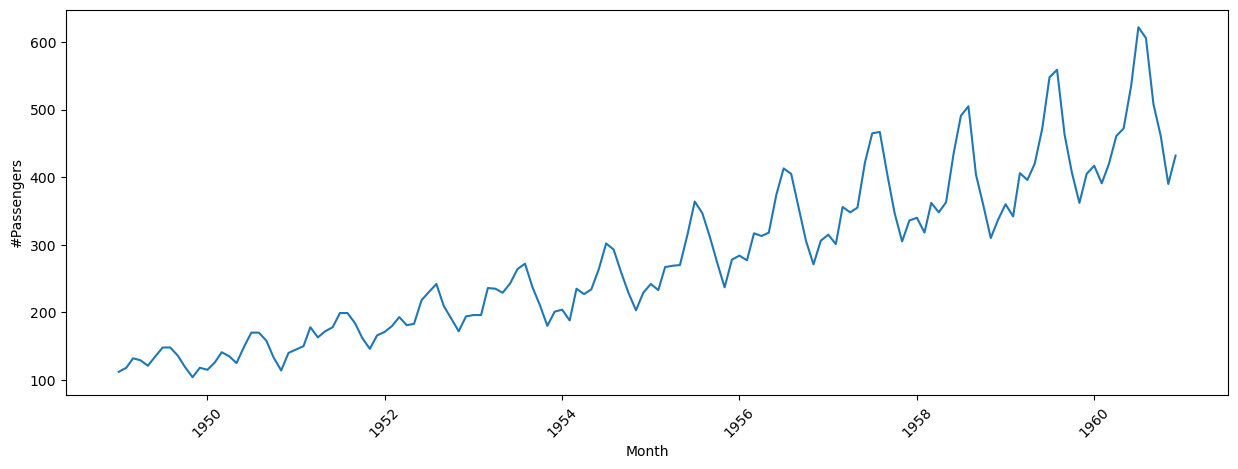

In [4]:
plot_lineplot_time_series(AirPassengers, "Month", "#Passengers")

## 0.2 Air Quality Dataset

In [5]:
# Initial loading - Separator is different here
AirQualityUCI = pd.read_csv("./datasets/AirQualityUCI.csv", sep=";")

# Convert date_column to datetime format
AirQualityUCI['Date'] = pd.to_datetime(AirQualityUCI['Date'])

# Convert time_column to timedelta format
AirQualityUCI['Time'] = pd.to_timedelta(AirQualityUCI['Time'].str.replace(".", ":"))

# Merge both fields
AirQualityUCI['DateTime'] = AirQualityUCI['Date'] + AirQualityUCI['Time']

# Drop columns
AirQualityUCI = AirQualityUCI.drop(['Date', 'Time'], axis=1)

# Reformat columns
cols = ['CO(GT)', 'T', 'RH', 'AH']
for col in cols:
    AirQualityUCI[col] = AirQualityUCI[col].str.replace(",", ".").replace('-200', None).astype('float')

# Take only an interval of dates
start_date = "23-03-2004"
end_date = "01-03-2005"
AirQualityUCI = AirQualityUCI.loc[(AirQualityUCI['DateTime'] >= start_date) & (AirQualityUCI['DateTime'] <= end_date)]

AirQualityUCI.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6271 entries, 0 to 8526
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   CO(GT)         4879 non-null   float64       
 1   PT08.S1(CO)    6271 non-null   float64       
 2   NMHC(GT)       6271 non-null   float64       
 3   C6H6(GT)       6271 non-null   object        
 4   PT08.S2(NMHC)  6271 non-null   float64       
 5   NOx(GT)        6271 non-null   float64       
 6   PT08.S3(NOx)   6271 non-null   float64       
 7   NO2(GT)        6271 non-null   float64       
 8   PT08.S4(NO2)   6271 non-null   float64       
 9   PT08.S5(O3)    6271 non-null   float64       
 10  T              6047 non-null   float64       
 11  RH             6047 non-null   float64       
 12  AH             6047 non-null   float64       
 13  Unnamed: 15    0 non-null      float64       
 14  Unnamed: 16    0 non-null      float64       
 15  DateTime       6271 n

/var/folders/r1/qr8wrlpd13x_x7s4br12s4bm0000gn/T/ipykernel_20132/2116898129.py:5: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AirQualityUCI['Date'] = pd.to_datetime(AirQualityUCI['Date'])
/var/folders/r1/qr8wrlpd13x_x7s4br12s4bm0000gn/T/ipykernel_20132/2116898129.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  AirQualityUCI['Time'] = pd.to_timedelta(AirQualityUCI['Time'].str.replace(".", ":"))
/var/folders/r1/qr8wrlpd13x_x7s4br12s4bm0000gn/T/ipykernel_20132/2116898129.py:24: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AirQualityUCI = Ai

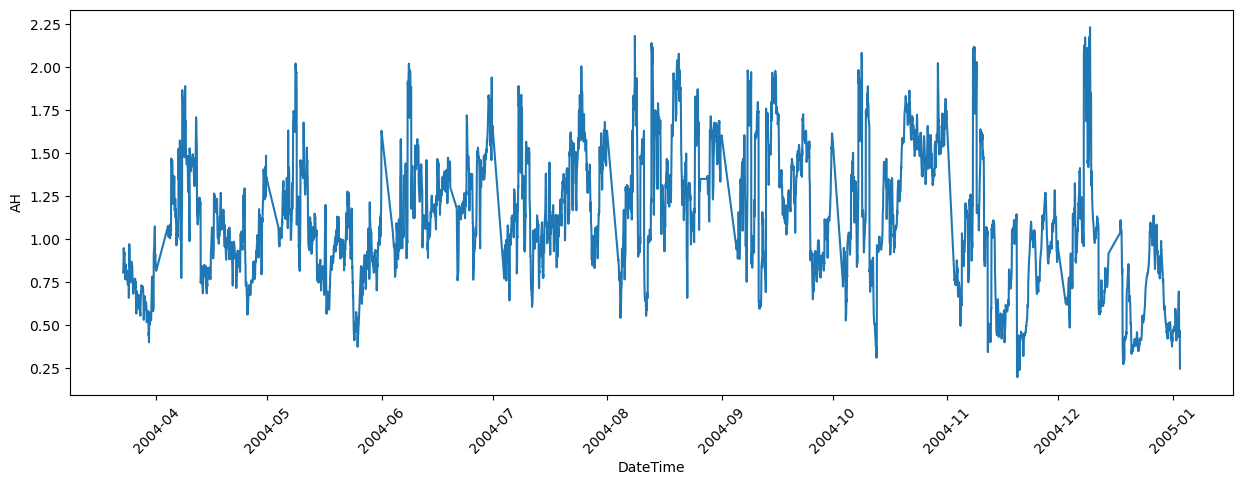

In [6]:
plot_lineplot_time_series(AirQualityUCI, "DateTime", "AH")

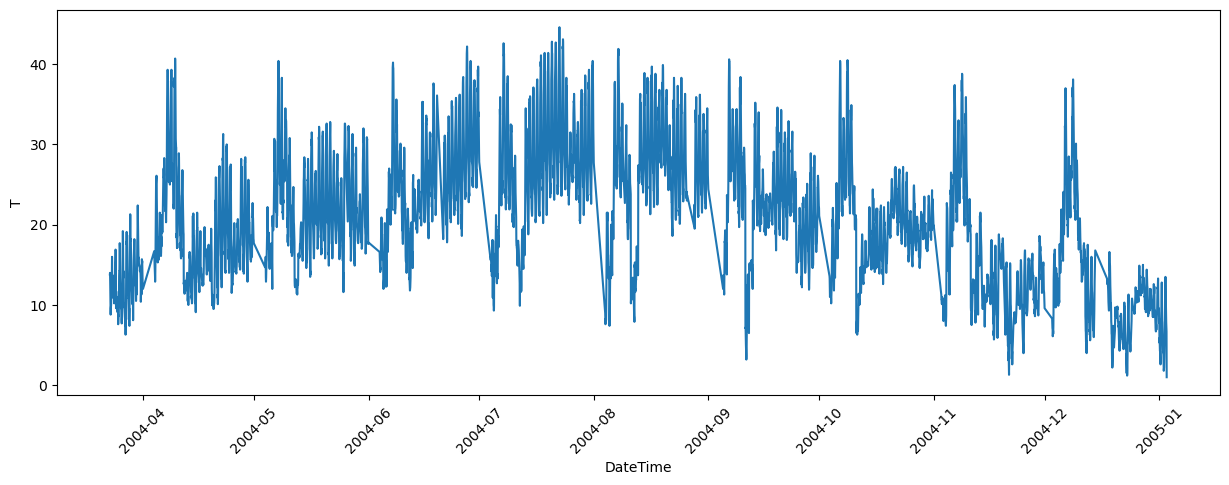

In [7]:
plot_lineplot_time_series(AirQualityUCI, "DateTime", "T")

# 1. Analyze Missing Data

For this example, I use the AirQuality dataset, with the variable T (Temperature).

I use two strategies:
- Forward-fill
- Moving Average

The difference is not significant here. However, because this variable is really noisy, I would go for a moving average.

The proposed strategies are imputation strategies: replace the value with the result of FF or Moving Average. An alternative strategy is to perform interpolation.

In [9]:
# Forward Fill
AirQualityUCI["T_FFill"] = AirQualityUCI['T'].fillna(method='ffill')

In [10]:
# Moving Average - Window of 5
AirQualityUCI["T_MovingAv"] = AirQualityUCI['T'].fillna(AirQualityUCI['T'].rolling(window=5, min_periods=1).mean())

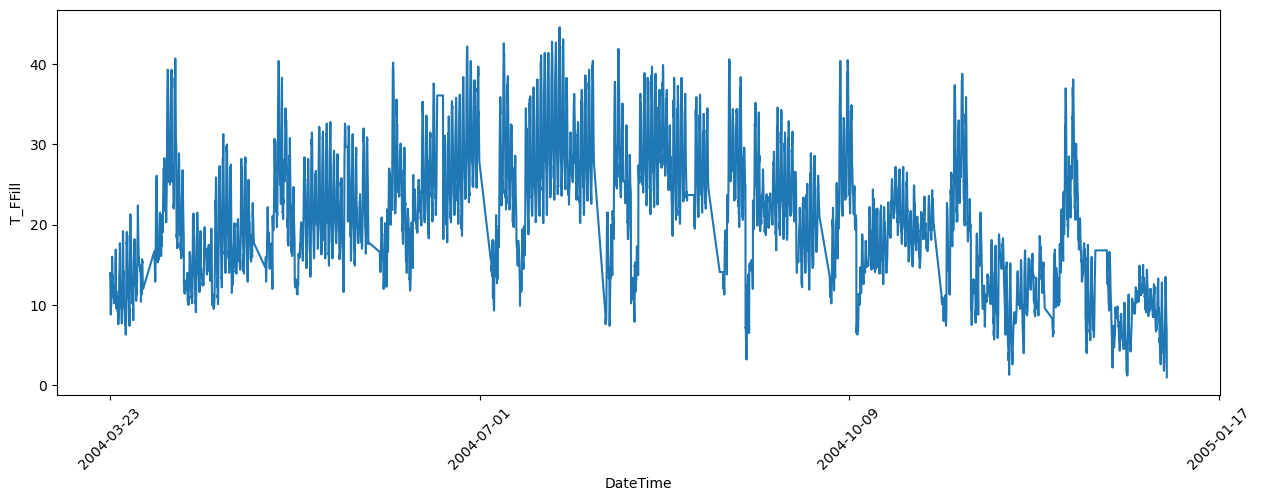

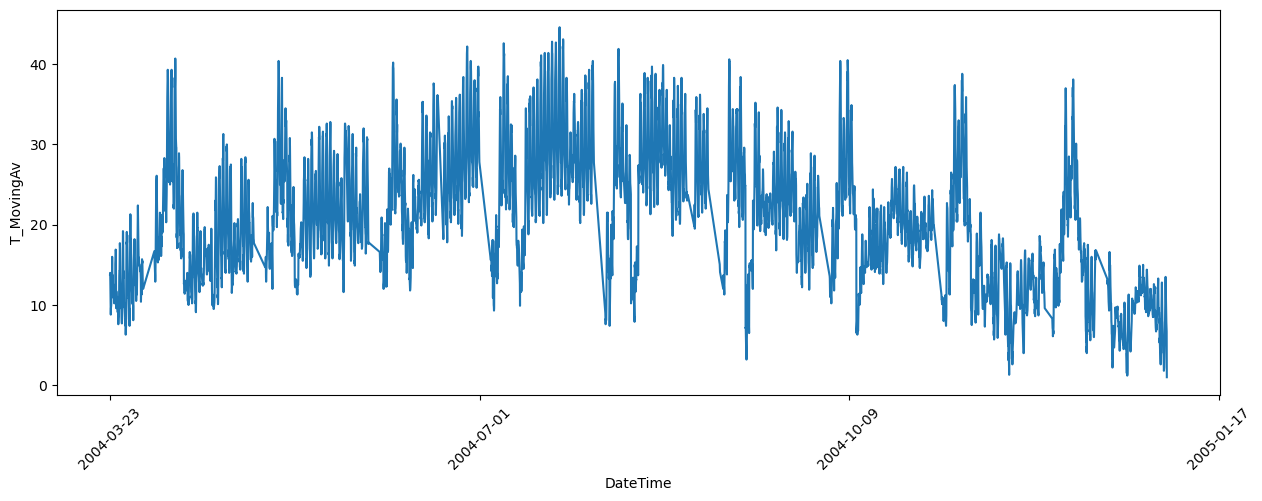

In [11]:
# Plot both results
plot_lineplot_time_series(AirQualityUCI, "DateTime", "T_FFill")
plot_lineplot_time_series(AirQualityUCI, "DateTime", "T_MovingAv")

# 2. Resampling

These methods modify the sampling frequency of the time series. 

## 2.1. Downsampling
Downsample reduces the sampling frequency, using a variety of methods:
- Mean: Take the average of a period
- Sum: Accumulate values. This is not suitable for all measurements
- Median: Take the median of a period
- Max: Take the max of a period

/var/folders/r1/qr8wrlpd13x_x7s4br12s4bm0000gn/T/ipykernel_2759/4029785464.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  AirQualityUCI_downsampled = AirQualityUCI.set_index('DateTime').resample('D').mean().reset_index()


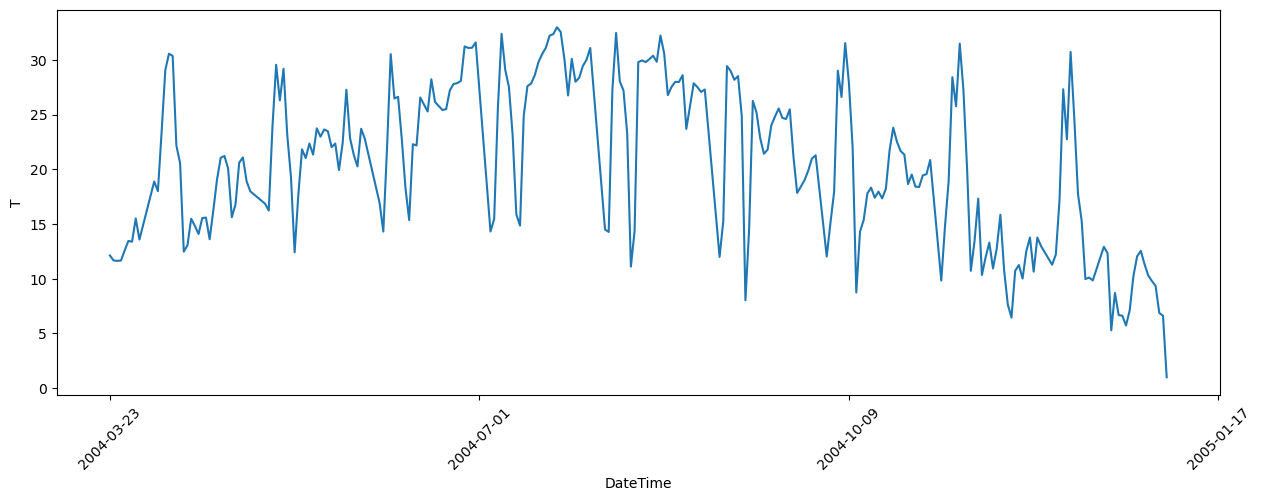

In [12]:
# Downsampling for a day - Mean
AirQualityUCI_downsampled = AirQualityUCI.set_index('DateTime').resample('D').mean().reset_index()
plot_lineplot_time_series(AirQualityUCI_downsampled, "DateTime", "T")

/var/folders/r1/qr8wrlpd13x_x7s4br12s4bm0000gn/T/ipykernel_2759/4019363897.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  AirQualityUCI_downsampled = AirQualityUCI.set_index('DateTime').resample('D').median().reset_index()


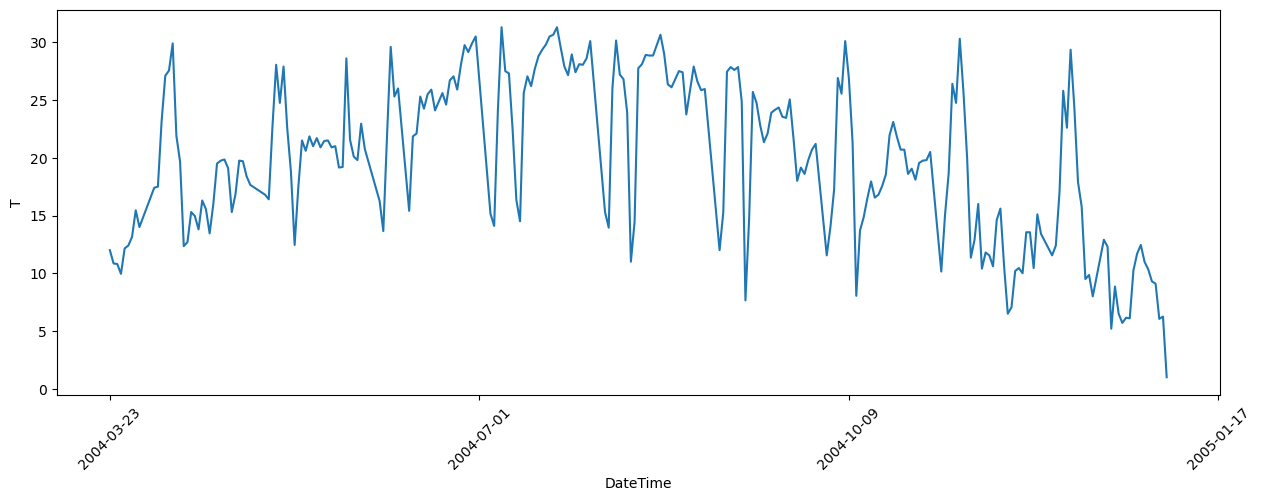

In [15]:
# Downsampling for a day - Median
AirQualityUCI_downsampled = AirQualityUCI.set_index('DateTime').resample('D').median().reset_index()
plot_lineplot_time_series(AirQualityUCI_downsampled, "DateTime", "T")

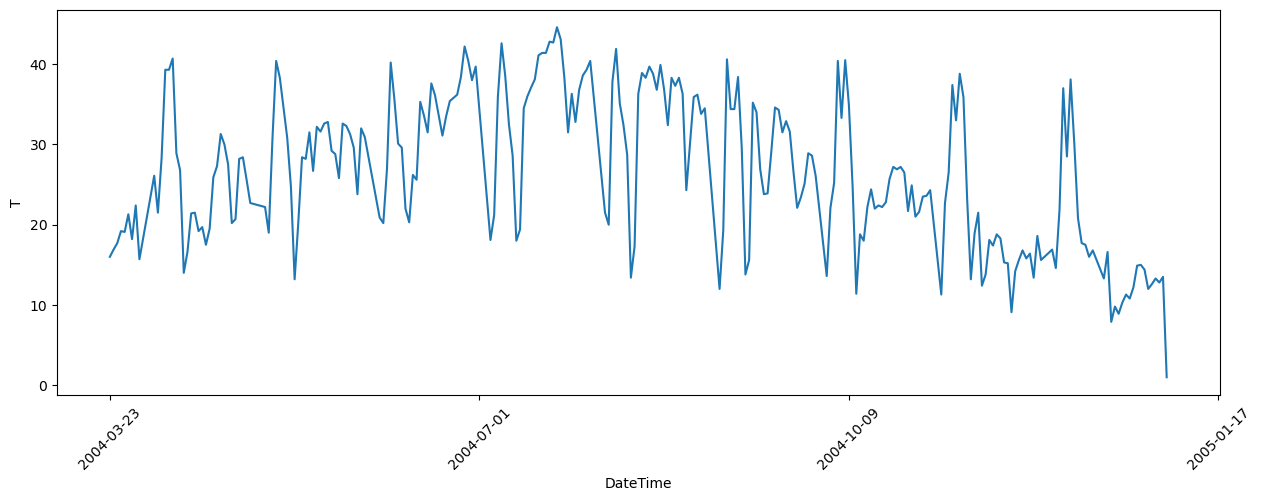

In [16]:
# Downsampling for a day - Max
AirQualityUCI_downsampled = AirQualityUCI.set_index('DateTime').resample('D').max().reset_index()
plot_lineplot_time_series(AirQualityUCI_downsampled, "DateTime", "T")

/var/folders/r1/qr8wrlpd13x_x7s4br12s4bm0000gn/T/ipykernel_2759/1289400878.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  AirQualityUCI_downsampled = AirQualityUCI.set_index('DateTime').groupby(pd.Grouper(freq='2D')).mean().reset_index()


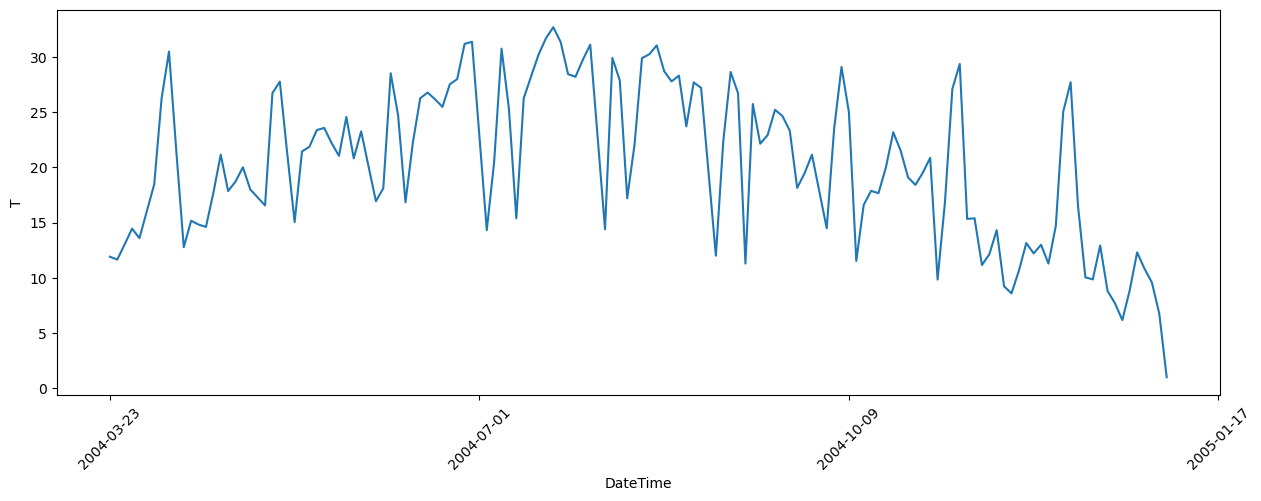

In [14]:
# Downsampling with custom gruoper
AirQualityUCI_downsampled = AirQualityUCI.set_index('DateTime').groupby(pd.Grouper(freq='2D')).mean().reset_index()
plot_lineplot_time_series(AirQualityUCI_downsampled, "DateTime", "T")

## 2.2. Upsampling
Upsampling creates new samples from the existing ones. This problem can be approached in a similar fashion as the missing data, using either imputation or interpolation.

For this problem, I use the Air Passengers dataset.

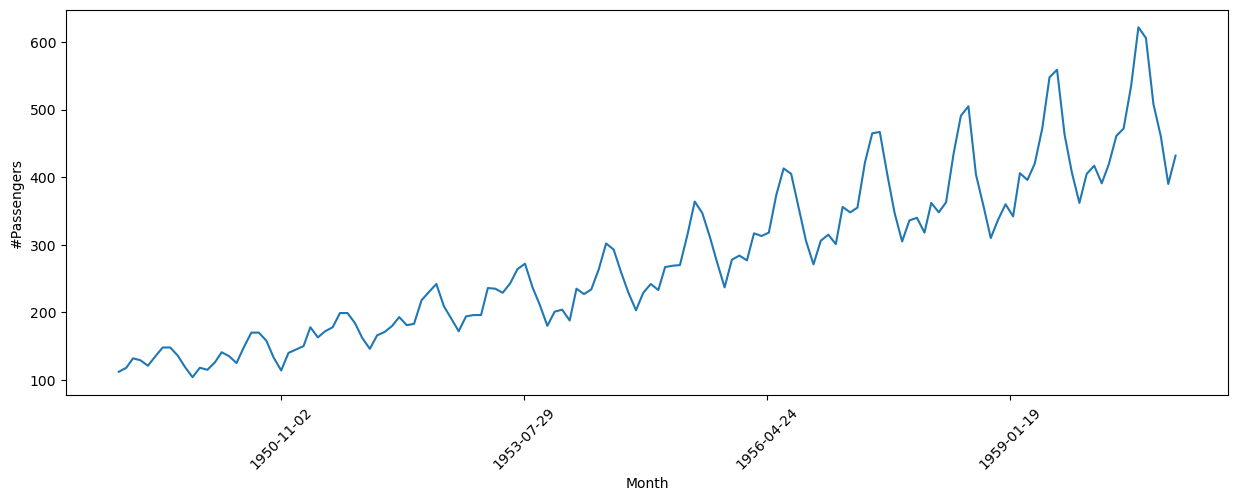

In [25]:
# Original dataset
plot_lineplot_time_series(AirPassengers, "Month", "#Passengers")

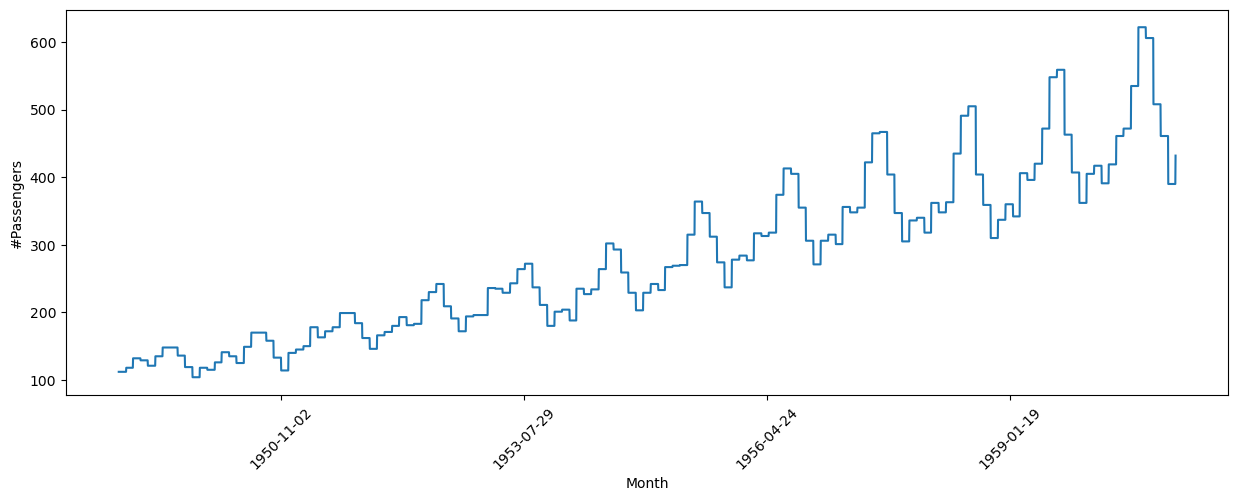

In [28]:
# Upsampled to 1 day using FF
AirPassengers_upsampled = AirPassengers.set_index("Month").resample('D').ffill().reset_index()
plot_lineplot_time_series(AirPassengers_upsampled, "Month", "#Passengers")

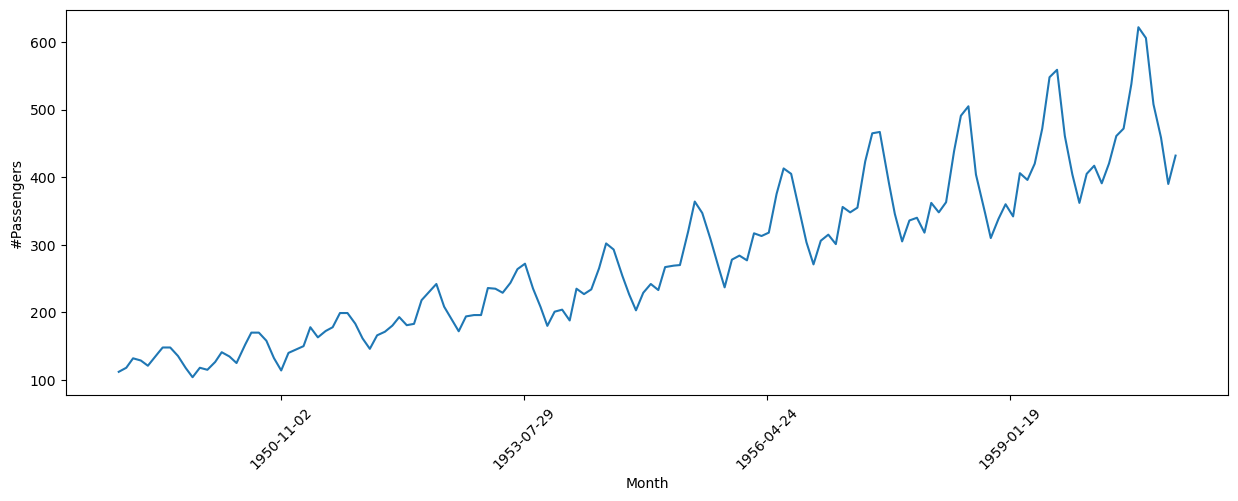

In [29]:
# Upsampled to 1 day using interpolation
AirPassengers_upsampled = AirPassengers.set_index("Month").resample('D').interpolate(method='linear').reset_index()
plot_lineplot_time_series(AirPassengers_upsampled, "Month", "#Passengers")

# 3. Smoothing

This techniques eliminate the high frequency components (i.e. spikes and abnormal values) by averaging over a window.
I explore two main strategies:
- Moving average, using only backwards data. This could also be done with forwards and centered data, but this can lead to lookahead.
- Exponential smoothing

I use the AirQuality dataset for this purpose.

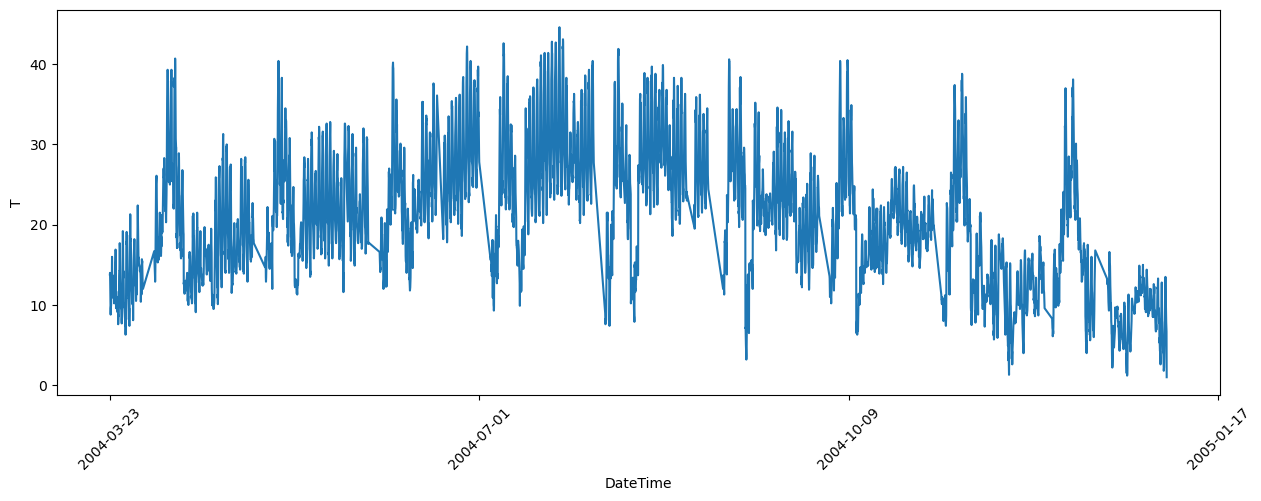

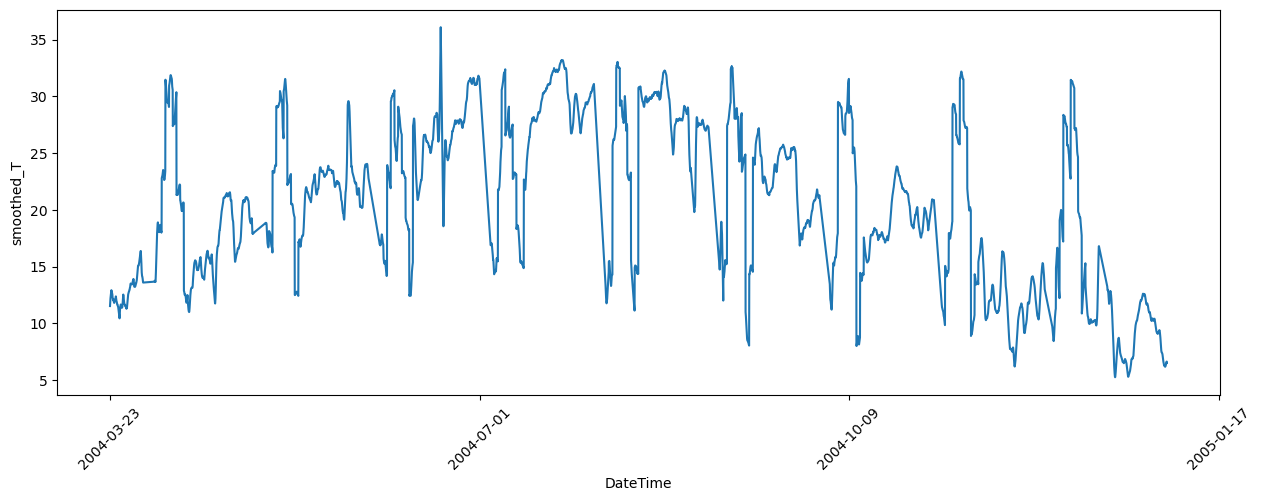

In [37]:
# Perform moving average smoothing
window_size = 24
AirQualityUCI['smoothed_T'] = AirQualityUCI['T'].rolling(window=window_size, min_periods=1).mean()

# Plot original and result
plot_lineplot_time_series(AirQualityUCI, "DateTime", "T")
plot_lineplot_time_series(AirQualityUCI, "DateTime", "smoothed_T")

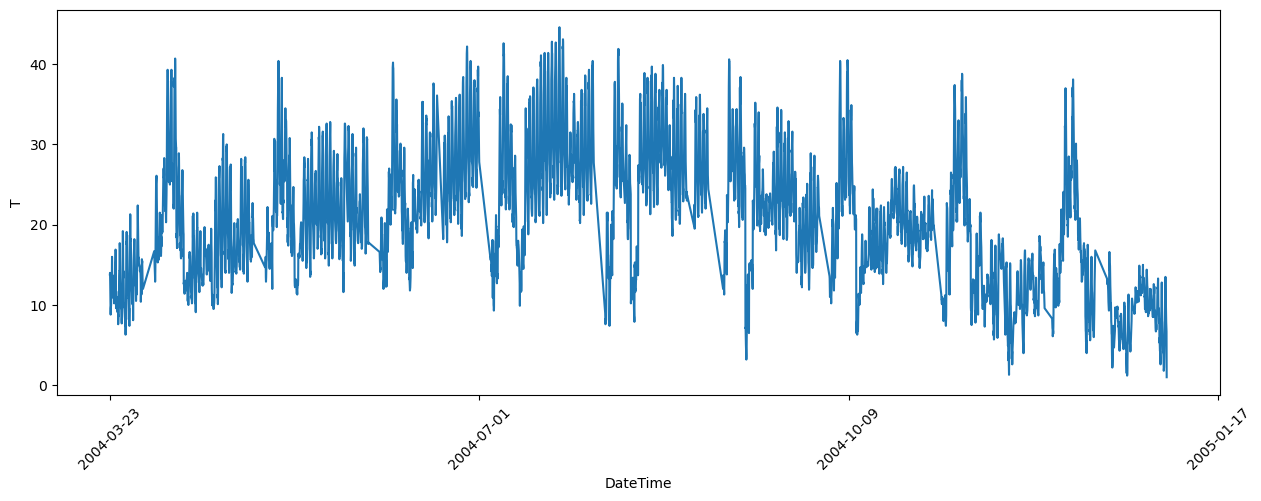

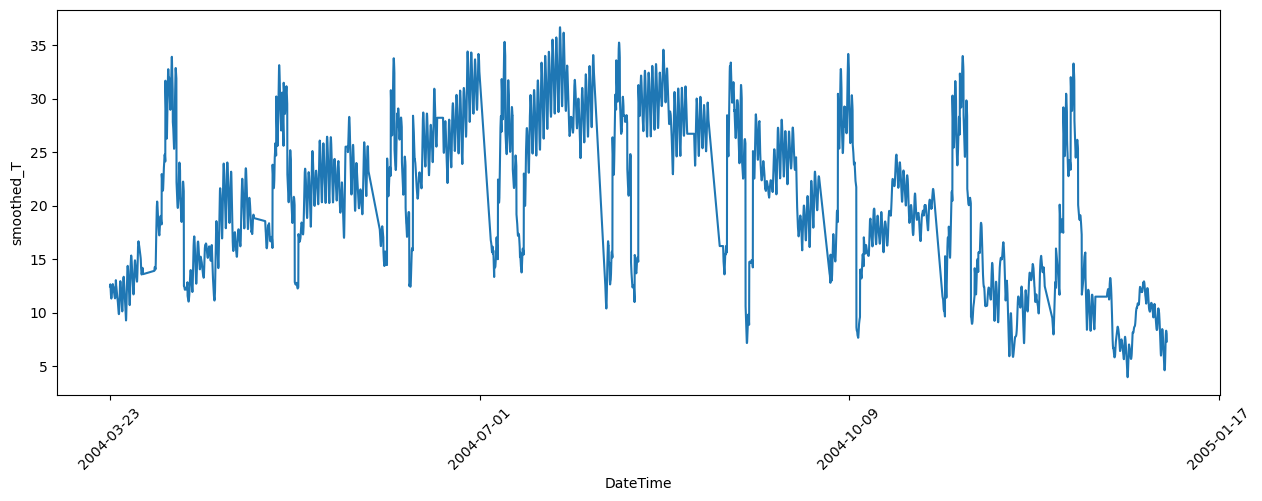

In [56]:
# Perform moving average smoothing
alpha = 0.1
AirQualityUCI['smoothed_T'] = AirQualityUCI['T'].ewm(alpha=alpha, adjust=False, ignore_na=True).mean()

# Plot original and result
plot_lineplot_time_series(AirQualityUCI, "DateTime", "T")
plot_lineplot_time_series(AirQualityUCI, "DateTime", "smoothed_T")

# 4. Seasonal Data

One last step is to separate the recurring behaviour on a time series, splitting it into:
- Trend: The low-frequency component on how the signal is evolving
- Seasonality: Fluctuations with stable frequency
- Residue: What's left in the signal

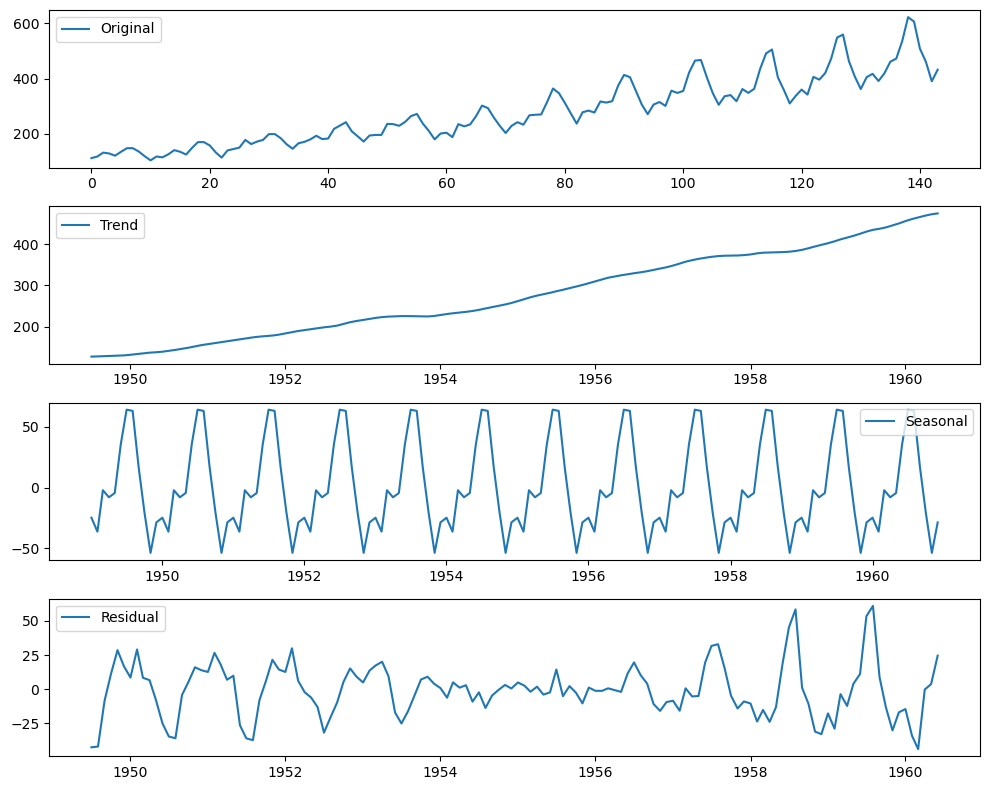

In [65]:
# Decompose the seasonal data
result = seasonal_decompose(AirPassengers.set_index('Month')['#Passengers'], model='additive')

# Plot the decomposed components
plt.figure(figsize=(10, 8))

plt.subplot(4, 1, 1)
plt.plot(AirPassengers['#Passengers'], label='Original')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(result.trend, label='Trend')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(result.seasonal, label='Seasonal')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(result.resid, label='Residual')
plt.legend()

plt.tight_layout()
plt.show()